# Prerequisuites 

** 1. Conda Environment **


    Please create a Python 3.10-3.12 Conda environment with below commands. 

        conda create -n graph python=3.11 -y && conda activate graph

        pip install graphrag

        conda activate graph

    We will use the "graph" Conda environment to run the below notebook and create the graph indexes.

** 2. Input Data **

    The text file need to be placed inside an **input** folder so that the Graph init command can read the text files

        - The file location for this notebook is a local drive

    You can also use the Microsoft Fabric OneLake location by following below steps 

        - Download and Install the Onelake file explorere from https://www.microsoft.com/en-us/download/details.aspx?id=105222 

        - Once installed you will be able to browse to your Fabric workspace and oneLake

        - Copy the text file which you want to be gaphed inside the Files folder in oneLake

# GraphRag Initialization

        use init Command to initialize the Grapgh , in our case the text files are inside **/input** folder

        init command will craete .env and settings.yaml files and a prompts folder with the default prompts to extract the graph entities

        Prior to running the indexing job in next cell, please update the below values in llm, embeddings and snapshots sections in settings.yaml

        llm:
            api_key: <api key for Azure Open AI model>
            type: azure_openai_chat
            model: gpt-4o
            model_supports_json: true # recommended if this is available for your model.
            max_tokens: 4096
            request_timeout: 180.0
            api_base: https://xxxx.openai.azure.com
            api_version: 2024-02-15-preview
            organization: Microsoft
            deployment_name: <Name of your deployment>

        embeddings:
        ## parallelization: override the global parallelization settings for embeddings
        async_mode: threaded # or asyncio
        # target: required # or all
            llm:
                api_key: <api key for Azure Open AI model>
                type: azure_openai_embedding
                model: text-embedding-3-large
                api_base: https://xxxx.openai.azure.com
                api_version: 2024-02-15-preview
                organization: Microsoft
                deployment_name: <Name of your deployment>

        snapshots:
                graphml: true
                raw_entities: true
                top_level_nodes: true

        
        Update the .env file and provide the azure open ai api key in the file 

            
         Note: setting gaphml parameter to true to create the graph for visualization   


In [ ]:
!python -m graphrag.index --init --root "C:\ragtests"
#!python -m graphrag.index --init --root "C:\Users\safdarzaman\OneLake - Microsoft\My workspace\yellowtaxidatalakehouse.Lakehouse\Files\Ragdata"

# Graph Indexing

        grarah.index pipeline will create the  parquet files under the output folder with entities, relatiosnships and community reports 

In [ ]:
!python -m graphrag.index --root C:\ragtests
#!python -m graphrag.index --root "C:\Users\safdarzaman\OneLake - Microsoft\My workspace\yellowtaxidatalakehouse.Lakehouse\Files\Ragdata"

        after successful running of the index pipeline you will have multiple parquet and graphml files under artifacts folder

# Visulaize the Graph

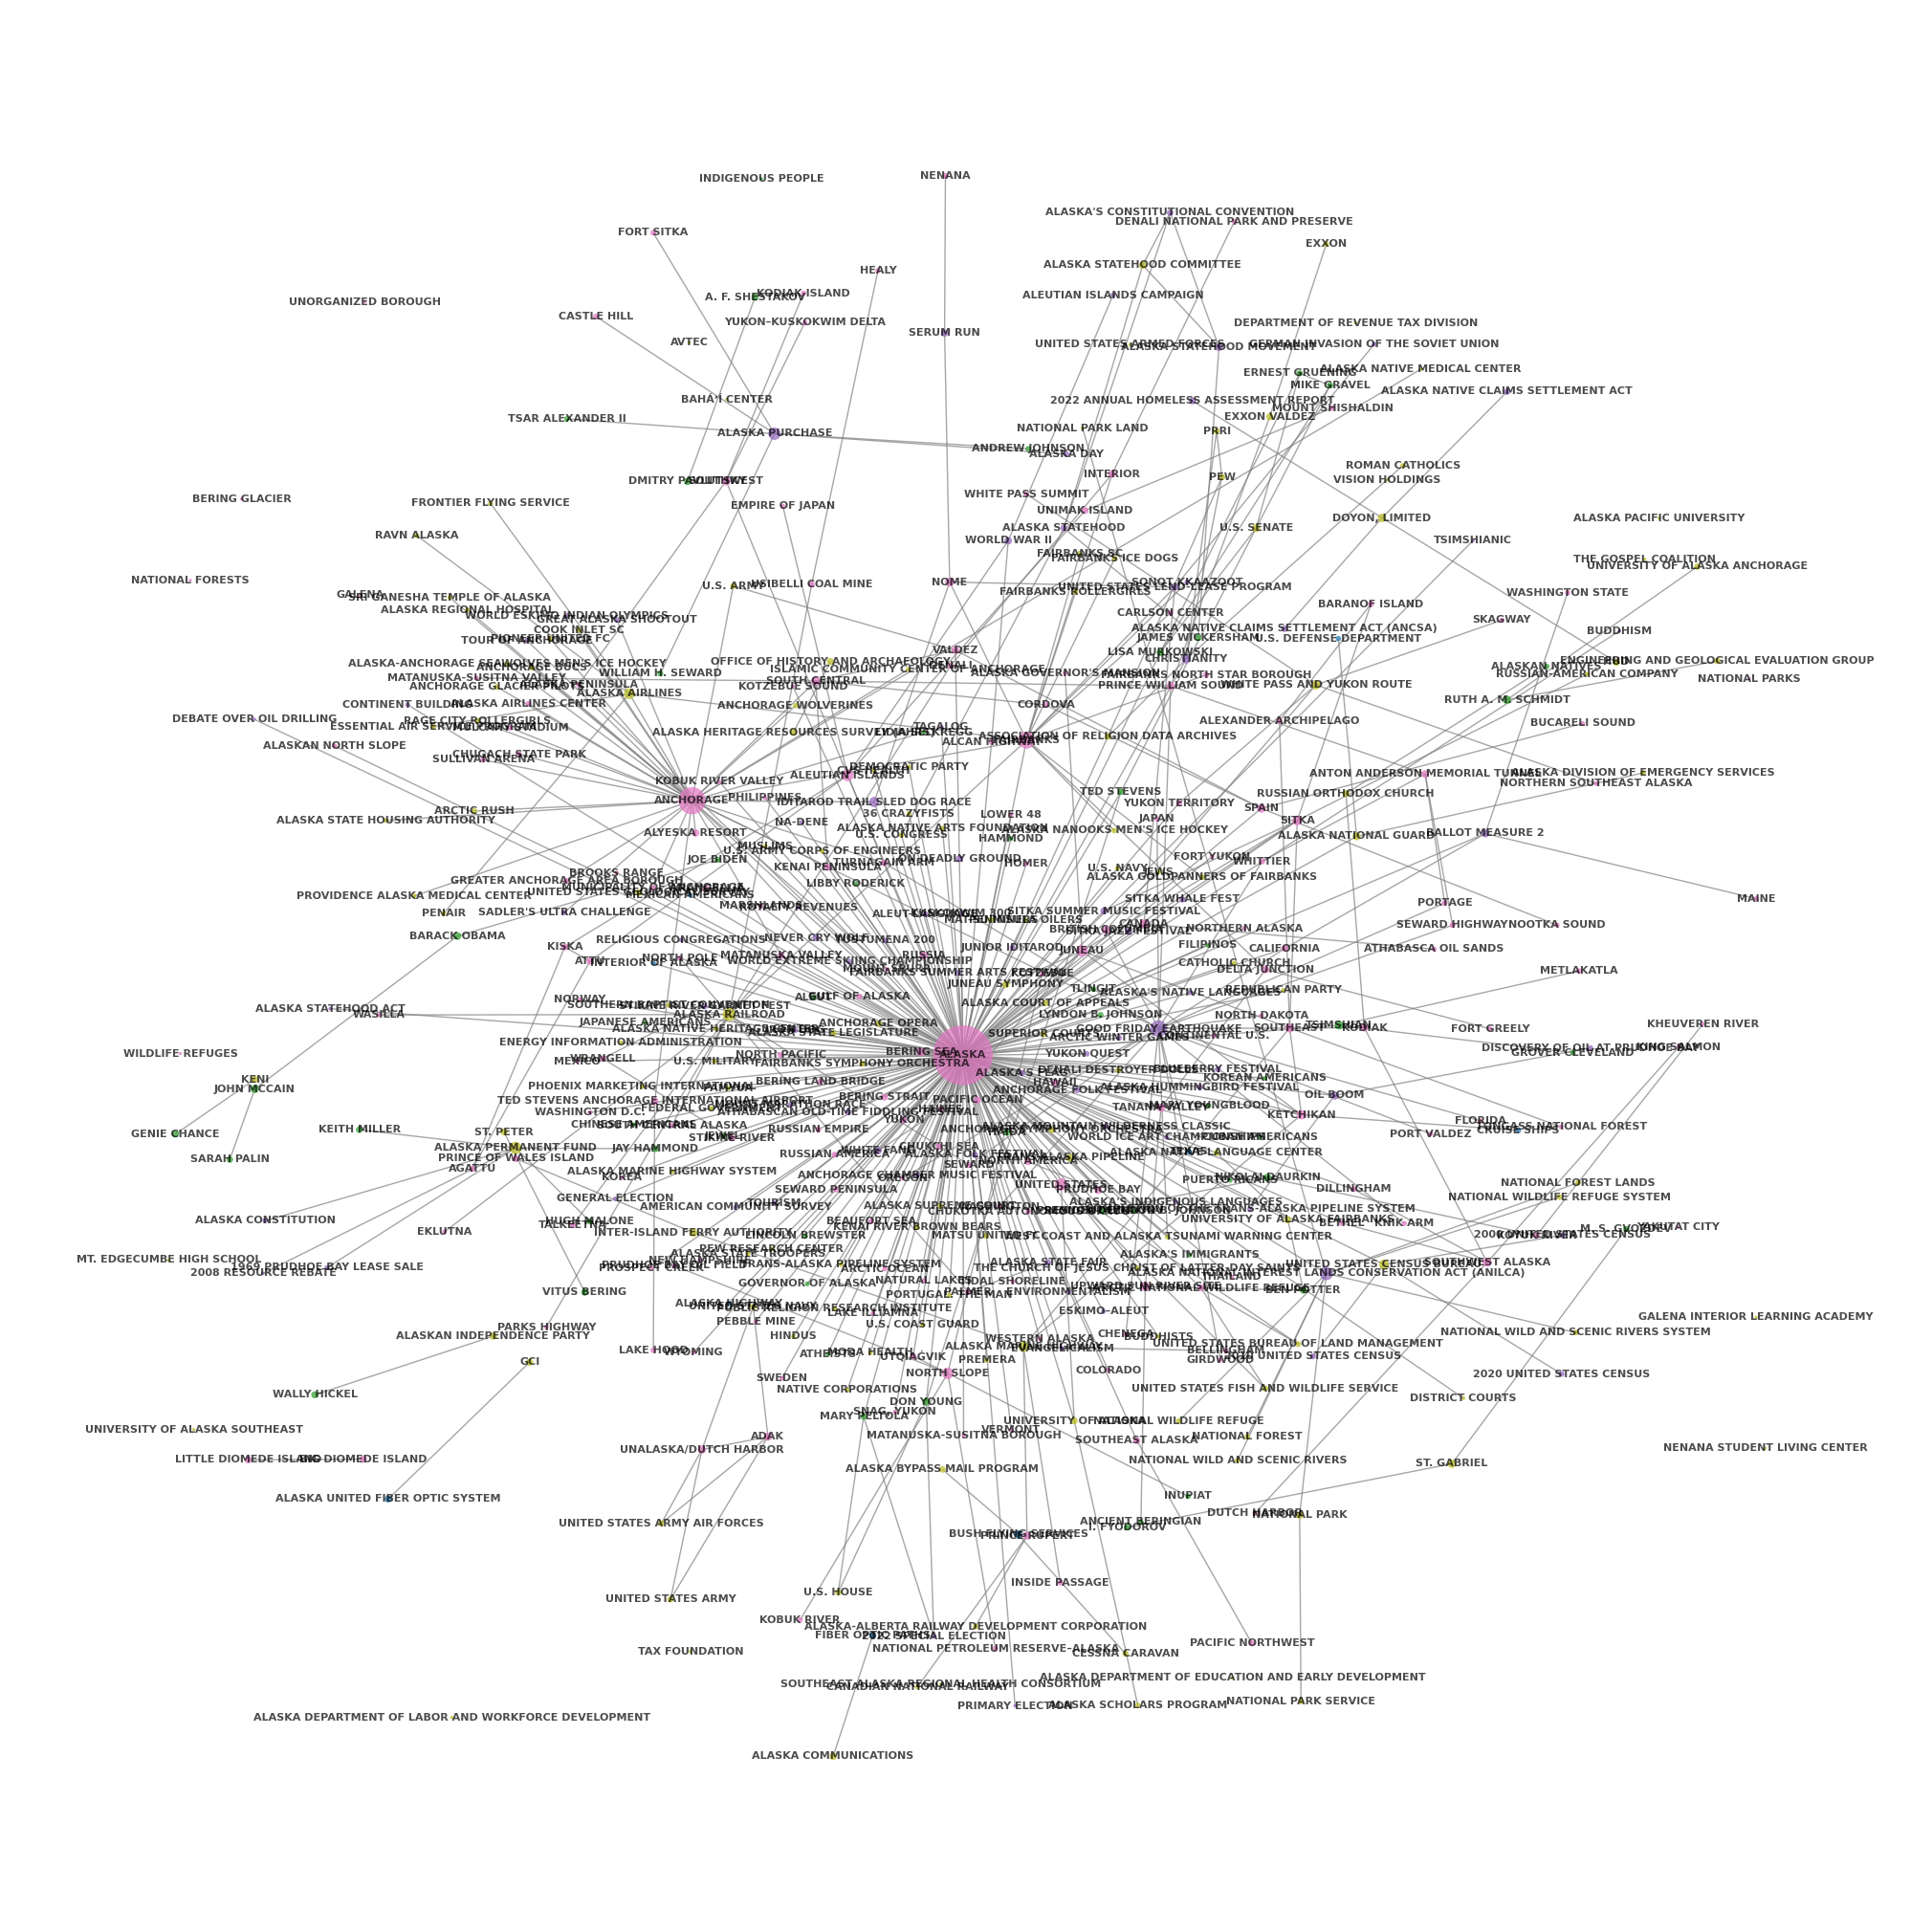

In [1]:
# In the artifacts folder you should have garphml files craeted 

import glob
import networkx as nx
import matplotlib.pyplot as plt

# Load the GraphML file
graph = nx.read_graphml(glob.glob("C:/ragtests/output/20240927-154127/artifacts/summarized_graph.graphml")[0])

for node in graph.nodes:
    graph.nodes[node].update({**graph.nodes[node], **{"label": node}})

nx.write_graphml(graph, "label_fix.graphml")

plt.figure(figsize=(20, 20))
# Extract node types
node_types = nx.get_node_attributes(graph, 'type')

# Define a color map for the node types
unique_types = list(set(node_types.values()))
color_map = {node_type: plt.cm.tab20(i / len(unique_types)) for i, node_type in enumerate(unique_types)}

# Assign colors to nodes based on their type
node_colors = [color_map[node_types[node]] if node in node_types else "r" for node in graph.nodes]

# Calculate PageRank
pagerank = nx.pagerank(graph)

# Assign node sizes based on PageRank
node_sizes = [pagerank[node] * 10000 for node in graph.nodes]

pos = nx.spring_layout(graph, k=0.20, iterations=20)
nx.draw(graph, pos, with_labels=True, node_size=node_sizes, font_size=8, font_color='black', font_weight='bold', node_color=node_colors, edge_color='gray', linewidths=0.5, alpha=0.7)
plt.show()

# Run queries on the created Graph entities 

In [ ]:
%pip install graphrag
%pip install azure-core
%pip install langchain
%pip install tiktoken
%pip install langchain-openai

In [2]:
import os
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import tiktoken
import pandas as pd

from graphrag.query.indexer_adapters import read_indexer_entities, read_indexer_reports
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding

from graphrag.query.llm.oai.typing import OpenaiApiType

from graphrag.query.structured_search.global_search.community_context import (
    GlobalCommunityContext,
)
from graphrag.query.structured_search.global_search.search import GlobalSearch

from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)


from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)

c:\Users\safdarzaman\AppData\Local\miniconda3\envs\grag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    Provide the LLM configuration which will be used by Graphrag at query time 

In [3]:
llm = ChatOpenAI(
    api_key="00ee1bb9c1424873a647df76dbd8c3b7",
    model="gpt4o",
    api_type=OpenaiApiType.AzureOpenAI,
    max_retries=20,
    api_base="https://assistantapitestuser.openai.azure.com",
    api_version="2024-02-15-preview",
)

text_embedder = OpenAIEmbedding(
    api_key="00ee1bb9c1424873a647df76dbd8c3b7",
    api_base="https://assistantapitestuser.openai.azure.com",
    api_type=OpenaiApiType.AzureOpenAI,
    model="text-embedding-3-large",
    deployment_name="text-embedding-3-large",
    max_retries=20,
    api_version="2024-02-15-preview",
)

token_encoder = tiktoken.get_encoding("cl100k_base")

    Provide the path of artifacts folder which has the Parquet files 
    Load the files in Pandas data frame

In [12]:
#INPUT_DIR = "C:/Users/safdarzaman/OneLake - Microsoft/My workspace/yellowtaxidatalakehouse.Lakehouse/Files/Ragdata/output/20240925-113329/artifacts"

INPUT_DIR = "C:/ragtests/output/20240927-154127/artifacts"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"




# parquet files generated from indexing pipeline
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_TABLE = "create_final_communities"

# community level in the Leiden community hierarchy from which we will load the community reports
# higher value means we use reports from more fine-grained communities (at the cost of higher computation cost)
COMMUNITY_LEVEL = 1



# read nodes table to get community and degree data

entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
community_df= pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_TABLE}.parquet")






reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
relationships = read_indexer_relationships(relationship_df)
text_units = read_indexer_text_units(text_unit_df)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

Print the count of Graph entities, relationships, text units and reports

In [ ]:
print(f"Entity count: {len(entity_df)}")
print(f"Relationship count: {len(relationship_df)}")

print(f"Text unit records: {len(text_unit_df)}")

print(f"Total report count: {len(report_df)}")

print(
    f"Report count after filtering by community level {COMMUNITY_LEVEL}: {len(reports)}"
)


# Print the data frames

In [29]:
#embedding dataframe
entity_embed_df.head()


,id,name,type,description,human_readable_id,graph_embedding,text_unit_ids,description_embedding
0,5eee450ef9c7485497b2a58fbb6419bf,ALASKA,GEO,Alaska is a non-contiguous U.S. state located ...,0,"[-0.007818687707185745, 0.018654003739356995, ...","[00d375540b94774f09bc5a0acc157bb3, 051f167f35b...","[0.03361629322171211, -0.006408105604350567, -..."
1,42cb3821f11b4d8d858240192265e15e,UNITED STATES,GEO,The United States is the country that includes...,1,"[0.02498815208673477, -0.03524506464600563, -0...","[051f167f35b49357a1c087c1ce5c37c9, 164341ba1b8...","[0.005828774534165859, 0.02035265602171421, -0..."
2,3f8b171ea5524a06994e025dffa8fa81,HAWAII,GEO,"Hawaii is a U.S. state that, along with Alaska...",2,"[9.949257218977436e-05, -0.023154329508543015,...","[00d375540b94774f09bc5a0acc157bb3, 6a46e183a72...","[0.03025517798960209, -0.00032390569685958326,..."
3,e7483a4738b54e9e88e177af687e90a5,YUKON,GEO,Yukon is a Canadian territory that borders Ala...,3,"[0.0013171748723834753, -0.003124299691990018,...","[051f167f35b49357a1c087c1ce5c37c9, a291debcf13...","[-0.003230628091841936, -0.005931737367063761,..."
4,30b5e1117a884bbc9cc2b0d84c6282f7,BRITISH COLUMBIA,GEO,British Columbia is a Canadian province that b...,4,"[-0.017786312848329544, -0.020923832431435585,...","[00d375540b94774f09bc5a0acc157bb3, 051f167f35b...","[0.024858340620994568, 0.013552089221775532, -..."


In [30]:
#relationship dataframe
relationship_df.head(40)

,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,ALASKA,UNITED STATES,74.0,Alaska is a state within the United States. It...,"[051f167f35b49357a1c087c1ce5c37c9, 164341ba1b8...",bc407cafbfd34e589e42422b631cef8d,0,207,4,211
1,ALASKA,HAWAII,22.0,Alaska and Hawaii are the only non-contiguous ...,"[6a46e183a72c7107b04a37535a6a8ec8, a291debcf13...",ea37f883f4ea4dd1b0f5df693b00c49f,1,207,2,209
2,ALASKA,YUKON,24.0,"Alaska and Yukon are neighboring regions, with...","[051f167f35b49357a1c087c1ce5c37c9, a291debcf13...",be624baf6fec49b0a85b9a481ddfbea7,2,207,1,208
3,ALASKA,BRITISH COLUMBIA,24.0,Alaska and British Columbia are neighboring re...,"[051f167f35b49357a1c087c1ce5c37c9, a291debcf13...",f500e5a5f7574944944875b6796d9654,3,207,3,210
4,ALASKA,RUSSIA,32.0,Alaska and Russia share a unique geographical ...,"[051f167f35b49357a1c087c1ce5c37c9, a291debcf13...",274883075fb248398a650ec798f58b49,4,207,2,209
5,ALASKA,CHUKOTKA AUTONOMOUS OKRUG,14.0,Alaska shares a maritime border with Russia's ...,[a291debcf1352cd2c9527ca3f2b43f4c],139ec41b1e7f4d68a2f067f1f7272d54,5,207,1,208
6,ALASKA,CHUKCHI SEA,22.0,The Chukchi Sea is located to the west and nor...,"[051f167f35b49357a1c087c1ce5c37c9, a291debcf13...",b8bb3a15b8af48238fe3b862551c17d3,6,207,1,208
7,ALASKA,BEAUFORT SEA,12.0,The Beaufort Sea lies to the north of Alaska,[a291debcf1352cd2c9527ca3f2b43f4c],68e7c7a4c00b43d4b944f0bcdc227715,7,207,1,208
8,ALASKA,PACIFIC OCEAN,30.0,The Pacific Ocean is located to the south and ...,"[051f167f35b49357a1c087c1ce5c37c9, 164341ba1b8...",94601c6789c44878aad74c6ea3465cd4,8,207,1,208
9,ALASKA,JUNEAU,40.0,"Juneau is the capital city of Alaska, known fo...","[051f167f35b49357a1c087c1ce5c37c9, 6a46e183a72...",046c5e364453449ab6066704bc6660ef,9,207,7,214


In [31]:
#textunit data frame
text_unit_df.head()

,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,a291debcf1352cd2c9527ca3f2b43f4c,Alaska ( ə-LASS-kə) is a non-contiguous U.S. ...,1200,[321cb1848a4ecc667e1365346ad119ca],"[5eee450ef9c7485497b2a58fbb6419bf, 42cb3821f11...","[bc407cafbfd34e589e42422b631cef8d, ea37f883f4e..."
1,daf9581c61d21abf1d5b3ed80f3ba360,es of Semyon Dezhnyov's expedition came ashore...,1200,[321cb1848a4ecc667e1365346ad119ca],"[5eee450ef9c7485497b2a58fbb6419bf, 42cb3821f11...","[bc407cafbfd34e589e42422b631cef8d, 274883075fb..."
2,00d375540b94774f09bc5a0acc157bb3,his tenure as a congressional delegate. Decad...,1200,[321cb1848a4ecc667e1365346ad119ca],"[5eee450ef9c7485497b2a58fbb6419bf, 3f8b171ea55...","[d14e4249ddf8407a907779131c50b023, 842b1ff7ca8..."
3,051f167f35b49357a1c087c1ce5c37c9,"of the public safety office, coordinating res...",1200,[321cb1848a4ecc667e1365346ad119ca],"[5eee450ef9c7485497b2a58fbb6419bf, 42cb3821f11...","[bc407cafbfd34e589e42422b631cef8d, be624baf6fe..."
4,164341ba1b819eb1950336bbc8726e37,. Geologists have identified Alaska as part of...,1200,[321cb1848a4ecc667e1365346ad119ca],"[5eee450ef9c7485497b2a58fbb6419bf, 42cb3821f11...","[bc407cafbfd34e589e42422b631cef8d, 94601c6789c..."


In [32]:
#report dataframe
report_df.head()

,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,54,# South Central Alaska and Kenai Peninsula\n\n...,2,6.5,South Central Alaska and Kenai Peninsula,The impact severity rating is moderately high ...,The community revolves around the South Centra...,[{'explanation': 'The Kenai Peninsula is a sig...,"{\n ""title"": ""South Central Alaska and Kena...",a5b40f94-8e60-414f-bcfa-e4f4d82db286
1,55,# Valdez Community and Historical Events\n\nTh...,2,6.5,Valdez Community and Historical Events,The impact severity rating is moderate to high...,"The community revolves around Valdez, a city i...",[{'explanation': 'Valdez is a city in South Ce...,"{\n ""title"": ""Valdez Community and Historic...",22df46d0-6a3c-4465-8f1e-203e45071278
2,56,# Spanish Expeditions and Settlements in Alask...,2,7.5,Spanish Expeditions and Settlements in Alaska,The impact severity rating is high due to the ...,The community revolves around the historical S...,[{'explanation': 'Spain sent several expeditio...,"{\n ""title"": ""Spanish Expeditions and Settl...",af6cf1d1-7e74-4e08-9221-2a243fd6846e
3,24,# Prudhoe Bay and Trans-Alaska Pipeline\n\nThe...,1,8.5,Prudhoe Bay and Trans-Alaska Pipeline,The impact severity rating is high due to the ...,"The community revolves around Prudhoe Bay, a s...",[{'explanation': 'Prudhoe Bay is recognized as...,"{\n ""title"": ""Prudhoe Bay and Trans-Alaska ...",765acc50-f21f-4acc-8c08-3850140c75b1
4,25,# Alaskan North Slope and United States Geolog...,1,7.5,Alaskan North Slope and United States Geologic...,The impact severity rating is high due to the ...,The community revolves around the Alaskan Nort...,[{'explanation': 'The Alaskan North Slope is i...,"{\n ""title"": ""Alaskan North Slope and Unite...",c510a183-fa51-48b3-9903-32329ec45960


# Run Global Search on data 

In [34]:
# Global serach is used to answer questions which need the complete dataset understanding for questions like "What are top 10 themes in articles"
context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,  # default to None if you don't want to use community weights for ranking
    token_encoder=token_encoder,
)


context_builder_params = {
    "use_community_summary": False,  # False means using full community reports. True means using community short summaries.
    "shuffle_data": True,
    "include_community_rank": True,
    "min_community_rank": 0,
    "community_rank_name": "rank",
    "include_community_weight": True,
    "community_weight_name": "occurrence weight",
    "normalize_community_weight": True,
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    "context_name": "Reports",
}

map_llm_params = {
    "max_tokens": 1000,
    "temperature": 0.0,
    "response_format": {"type": "json_object"},
}

reduce_llm_params = {
    "max_tokens": 2000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000-1500)
    "temperature": 0.0,
}


global_search_engine = GlobalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    max_data_tokens=12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
    map_llm_params=map_llm_params,
    reduce_llm_params=reduce_llm_params,
    allow_general_knowledge=False,  # set this to True will add instruction to encourage the LLM to incorporate general knowledge in the response, which may increase hallucinations, but could be useful in some use cases.
    json_mode=True,  # set this to False if your LLM model does not support JSON mode.
    context_builder_params=context_builder_params,
    concurrent_coroutines=32,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [36]:
#result = await global_search_engine.asearch("what is common between all three of states including  ALASKA and Washington, D.C and california, only mention the common thing between them")
#result = await global_search_engine.asearch("what is common law in all three of states including  ALASKA and Washington, D.C and california, only mention the common thing between them")
result = await global_search_engine.asearch("what is common theme in  ALASKA and Washington, D.C and california")


print(result.response)

### Common Themes in Alaska, Washington, D.C., and California

#### Electoral Reforms

A significant common theme among Alaska, California, and Washington State is the adoption of electoral reforms aimed at increasing transparency and promoting a more inclusive electoral process. Alaska's Ballot Measure 2, which established a non-partisan blanket primary system and ranked-choice voting, mirrors similar reforms in California and Washington State. These changes are designed to enhance voter representation and reduce the likelihood of extreme candidates winning elections [Data: Reports (42)].

#### Natural Disasters and Preparedness

Another shared experience between Alaska and Washington State is their history of natural disasters, particularly the Good Friday Earthquake. This earthquake caused extensive damage through tsunamis and landslides, affecting not only Alaska and Washington but also regions as far as Japan and Hawaii. The establishment of the West Coast and Alaska Tsunami Warni

In [37]:
# inspect the data used to build the context for the LLM responses
result.context_data["reports"]

,id,title,occurrence weight,content,rank
0,23,Alaska and Its Key Relationships,1.0000,# Alaska and Its Key Relationships\n\nThe comm...,8.5
1,27,Alaska and University of Alaska Community,0.5625,# Alaska and University of Alaska Community\n\...,6.5
2,40,Alaska Railroad and Connected Communities,0.3750,# Alaska Railroad and Connected Communities\n\...,7.5
3,15,Upward Sun River Site and Tanana Valley Community,0.3125,# Upward Sun River Site and Tanana Valley Comm...,7.5
4,34,Aleutian Islands and Historical Significance,0.2500,# Aleutian Islands and Historical Significance...,7.5
5,32,Alcan Highway and World War II in Alaska,0.1875,# Alcan Highway and World War II in Alaska\n\n...,7.5
6,18,North Slope Community in Alaska,0.1875,# North Slope Community in Alaska\n\nThe North...,7.5
7,52,Denali and the Interior Region of Alaska,0.1875,# Denali and the Interior Region of Alaska\n\n...,7.5
8,11,Alaska Marine Highway and Associated Entities,0.1875,# Alaska Marine Highway and Associated Entitie...,7.5
9,42,Ballot Measure 2 and Related States,0.1875,# Ballot Measure 2 and Related States\n\nThe c...,7.5


In [38]:
print(f"LLM calls: {result.llm_calls}. LLM tokens: {result.prompt_tokens}")

LLM calls: 4. LLM tokens: 31814


# Run Local Search on Data

In [39]:
# Local serach is used to answer questions which need the a very specific and granular part of ou graph for questions like "what is the name of country with X law"
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    # if you did not run covariates during indexing, set this to None
    #covariates=covariates,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}


local_search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [40]:
#result = await local_search_engine.asearch("what is common between all three of states including  ALASKA and Washington, D.C and california, only mention the common thing between them")
result = await local_search_engine.asearch("what is common law in all three of states including  ALASKA and Washington, D.C and california, only mention the common thing between them")

print(result.response)

### Common Law in Alaska, Washington D.C., and California

One notable commonality between Alaska, Washington D.C., and California is the legalization of recreational marijuana. All three jurisdictions have enacted laws that permit the use of marijuana for recreational purposes. 

- **Alaska**: Alaska was one of the first states to legalize recreational marijuana, alongside Washington and Colorado [Data: Entities (0, 102, 442)].
- **Washington D.C.**: The capital of the United States, Washington D.C., also allows the use of recreational marijuana [Data: Entities (443)].
- **California**: California followed suit and legalized recreational marijuana, making it one of the states where this is permitted [Data: Entities (104)].

This shared legal stance on recreational marijuana highlights a significant policy alignment among these three regions.
